In [1]:
import json
import os
import sys

#sys.path.append('/home/luis/CGE/luxgiant-dstream/luxgiant_dstream')
sys.path.append('/mnt/0A2AAC152AABFBB7/CGE/luxgiant-dstream')

from luxgiant_dstream.prep_ds import PrepDS
from luxgiant_dstream.gwas_fixed import GWASfixed
from luxgiant_dstream.gwas_random import GWASrandom

In [2]:
params = json.load(open("/mnt/0A2AAC152AABFBB7/data/LuxGiantimputed/configFiles/parameters.JSON"))
paths = json.load(open("/mnt/0A2AAC152AABFBB7/data/LuxGiantimputed/configFiles/paths_home_local.JSON"))

#params = json.load(open("//home/luis/data/LuxGiantimputed/configFiles/parameters.JSON"))
#paths = json.load(open("/home/luis/data/LuxGiantimputed/configFiles/paths_local.JSON"))

In [3]:
import pandas as pd
import gwaslab as gl

In [4]:
path_2_gwas = "/mnt/0A2AAC152AABFBB7/data/LuxGiantimputed/outputData/gwas_fixed"
filename = "ds_results_glm.PHENO1.glm.logistic.hybrid"

df_gwas = pd.read_csv(os.path.join(path_2_gwas, filename), sep='\t', usecols=['CHR', 'POS', 'SNP', 'p'])
df_gwas = df_gwas[df_gwas['p']<0.5e-6].reset_index(drop=True)
df_gwas

,CHR,POS,SNP,p
0,1,204843922,rs12217091,3.727310e-07
1,1,205681143,rs1775153,4.046000e-07
2,1,205682349,rs1772136,4.046000e-07
3,1,205684628,rs6685188,4.579400e-07
4,1,205691812,rs12132270,5.982770e-08
...,...,...,...,...
1320,22,41309905,rs9611549,4.954790e-08
1321,22,41311050,rs9611550,4.986100e-08
1322,22,41314030,rs6002328,8.919460e-08
1323,22,41317107,rs9611555,6.118370e-08


In [20]:
import matplotlib.pyplot as plt

def process_density(sumstats: pd.DataFrame, bwindowsizekb: int, chrom: str, pos: str, verbose: bool, log):
    
    from gwaslab.viz_aux_quickfix import _get_largenumber

    # Logging the start of density calculation
    log.write(f" -Calculating DENSITY with windowsize of {bwindowsizekb} kb", verbose=verbose)
    
    # Generate a large number for scaling
    large_number = _get_largenumber(sumstats[pos].max(), log=log)
    
    # Create 'TCHR+POS' by combining chrom and pos
    sumstats["TCHR+POS"] = sumstats[chrom] * large_number + sumstats[pos]
    
    # Sort by 'TCHR+POS'
    sumstats = sumstats.sort_values(by="TCHR+POS")
    
    # Initialize the density column
    sumstats["DENSITY"] = 0
    
    # Calculate the window size in the same unit as 'TCHR+POS'
    window_size = 1000 * bwindowsizekb

    # Use a rolling window approach to count the number of SNPs within the window
    for idx, row in sumstats.iterrows():
        # Create a mask for rows within the window
        within_window = (sumstats["TCHR+POS"] >= (row["TCHR+POS"] - window_size)) & (sumstats["TCHR+POS"] < row["TCHR+POS"])
        
        # Calculate density for the current row
        density_count = within_window.sum()
        
        # Update density for the current row and all rows within the window
        sumstats.loc[within_window, "DENSITY"] += 1
        sumstats.loc[idx, "DENSITY"] += density_count

    # Compute mean and median density
    bmean = sumstats["DENSITY"].mean()
    bmedian = sumstats["DENSITY"].median()

    return sumstats, bmean, bmedian


def draw_brisbane(gwas_df:pd.DataFrame, plot_dir:str=None)->bool:

    from gwaslab.g_Log import Log

    df = gwas_df.copy()

    df, mean, median = process_density(
        gwas_df, 
        bwindowsizekb=100, 
        chrom='CHR', 
        pos='POS', 
        verbose=False, log=Log()
    )

    fig, ax = plt.subplots(figsize=(15, 5))

    sig_level=1,
    sig_line=False,
    windowsizekb = 100000000   
    mode="mb"
    scatter_args={"marker":"s"}
    marker_size= (5,20)
    cols_to_use = ['P', 'CHR', 'POS', 'SNPID', 'DENSITY']

    from gwaslab.viz_plot_mqqplot import _process_p_value

    df = _process_p_value(
        sumstats=df, 
        mode=mode,
        p='P', 
        mlog10p="MLOG10P", 
        scaled=False, 
        log=Log(), 
        verbose=True
    )

    return df

In [6]:
gwas_lab = gl.Sumstats(df_gwas, chrom='CHR', pos='POS', snpid='SNP', p='p')
gwas_lab.data['CHR'] = gwas_lab.data['CHR'].astype(int)

2024/10/17 16:42:28 GWASLab v3.4.48 https://cloufield.github.io/gwaslab/
2024/10/17 16:42:28 (C) 2022-2024, Yunye He, Kamatani Lab, MIT License, gwaslab@gmail.com
2024/10/17 16:42:28 Start to initialize gl.Sumstats from pandas DataFrame ...
2024/10/17 16:42:28  -Reading columns          : p,POS,SNP,CHR
2024/10/17 16:42:28  -Renaming columns to      : P,POS,SNPID,CHR
2024/10/17 16:42:28  -Current Dataframe shape : 1325  x  4
2024/10/17 16:42:28  -Initiating a status column: STATUS ...
2024/10/17 16:42:28  #WARNING! Version of genomic coordinates is unknown...
2024/10/17 16:42:29 Start to reorder the columns...v3.4.48
2024/10/17 16:42:29  -Current Dataframe shape : 1325 x 5 ; Memory usage: 19.99 MB
2024/10/17 16:42:29  -Reordering columns to    : SNPID,CHR,POS,P,STATUS
2024/10/17 16:42:29 Finished reordering the columns.
2024/10/17 16:42:29  -Column  : SNPID  CHR    POS   P       STATUS  
2024/10/17 16:42:29  -DType   : object string int64 float64 category
2024/10/17 16:42:29  -Verified:

In [13]:
from gwaslab.g_Log import Log
data, mean, median = process_density(df_gwas, 100, 'CHR', 'POS', False, Log())
data

,CHR,POS,SNP,p,TCHR+POS,DENSITY
0,1,204843922,rs12217091,3.727310e-07,10204843922,0
1,1,205681143,rs1775153,4.046000e-07,10205681143,73
2,1,205682349,rs1772136,4.046000e-07,10205682349,74
3,1,205684628,rs6685188,4.579400e-07,10205684628,78
4,1,205691812,rs12132270,5.982770e-08,10205691812,97
...,...,...,...,...,...,...
1320,22,41309905,rs9611549,4.954790e-08,220041309905,46
1321,22,41311050,rs9611550,4.986100e-08,220041311050,46
1322,22,41314030,rs6002328,8.919460e-08,220041314030,44
1323,22,41317107,rs9611555,6.118370e-08,220041317107,44


In [15]:
from luxgiant_dstream.plots import compute_relative_pos

data = compute_relative_pos(data, 'CHR', 'POS')
data


,CHR,POS,SNP,p,TCHR+POS,DENSITY,rel_pos,log10p
0,1,204843922,rs12217091,3.727310e-07,10204843922,0,204843922,6.428604
1,1,205681143,rs1775153,4.046000e-07,10205681143,73,205681143,6.392974
2,1,205682349,rs1772136,4.046000e-07,10205682349,74,205682349,6.392974
3,1,205684628,rs6685188,4.579400e-07,10205684628,78,205684628,6.339191
4,1,205691812,rs12132270,5.982770e-08,10205691812,97,205691812,7.223098
...,...,...,...,...,...,...,...,...
1320,22,41309905,rs9611549,4.954790e-08,220041309905,46,689959457,7.304975
1321,22,41311050,rs9611550,4.986100e-08,220041311050,46,689960602,7.302239
1322,22,41314030,rs6002328,8.919460e-08,220041314030,44,689963582,7.049661
1323,22,41317107,rs9611555,6.118370e-08,220041317107,44,689966659,7.213364


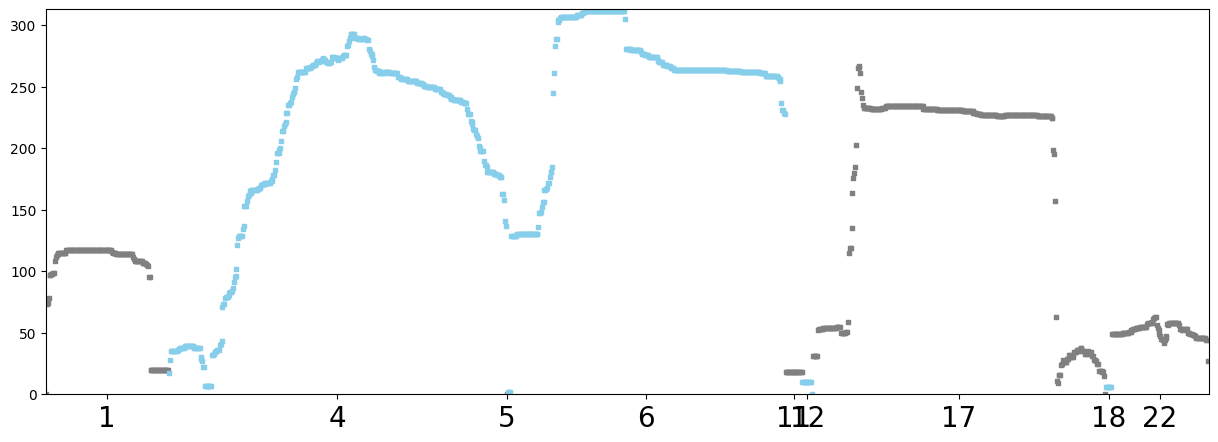

In [21]:
draw_brisbane(df_gwas)